In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu'
sys.path.append(os.getcwd()+"/..")
sys.path.append(os.getcwd()+"/dcgan/")

import theano.tensor as T
import theano

import lasagne

from tasks import check
from scripts import manifold
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from image_scatter import image_scatter
from tqdm import tqdm

%matplotlib inline
from IPython.display import Image

import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
from helpers import salt_and_pepper
def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

def floatX(x):
    return x.astype(np.float32)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Couldn't import dot_parser, loading of dot files will not be possible.


/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load model

In [2]:
#5a59f5a7094a3b585818e8e2117585c7
v = check(
    what="notebook", 
    filename="../training/brush6/model.pkl", 
    #filename="../training/initial_models/model_E.pkl",
    dataset='digits',
    #force_w=28,
    #force_h=28,
    #force_c=1,
    #mode='minibatch'
    #force_model_params=dict(use_wta_spatial=False, use_wta_channel=False)
)

Loading data...


INFO:tasks:Loading data...


(None, 44, 28, 28)
(None, 44, 28, 28)
Loading the model...


INFO:tasks:Loading the model...


(None, 44, 28, 28)
Compiling the model...


INFO:tasks:Compiling the model...


{'patience_stat': 'avg_loss_train_fix', 'epsilon': 1e-08, 'max_nb_epochs': 9999999999, 'batch_size': 128, 'initial_lr': 0.1, 'patience_nb_epochs': 800, 'lr_decay_method': 'none', 'beta2': 0.95, 'beta1': 0.95, 'min_nb_epochs': 100000, 'lr_decay': 0, 'momentum': 0.9, 'algo': 'adadelta'}


In [3]:
capsule, data, layers, w, h, c = v

In [4]:
for l in layers:
    print(l)

input
hid1
hid2
hid3
hid4
coord
brush
output


In [5]:
code_layers = ['wta_channel_conv1', 'wta_channel_conv2', 'wta_channel_conv3']
#code_layers = ['wta_channel']
#code_layers = ['wta_channel_conv1', 'wta_channel_conv2']

X = T.tensor4()
encode = theano.function(
    [X], 
    [L.get_output(layers[cc], X) for cc in code_layers]
)

code_t = [T.tensor4() for _ in code_layers]

decode = theano.function(
    code_t,
    L.get_output(layers['output'], {layers[name]: t for name, t in zip(code_layers, code_t)})
)

KeyError: 'wta_channel_conv1'

## viz features

hid1


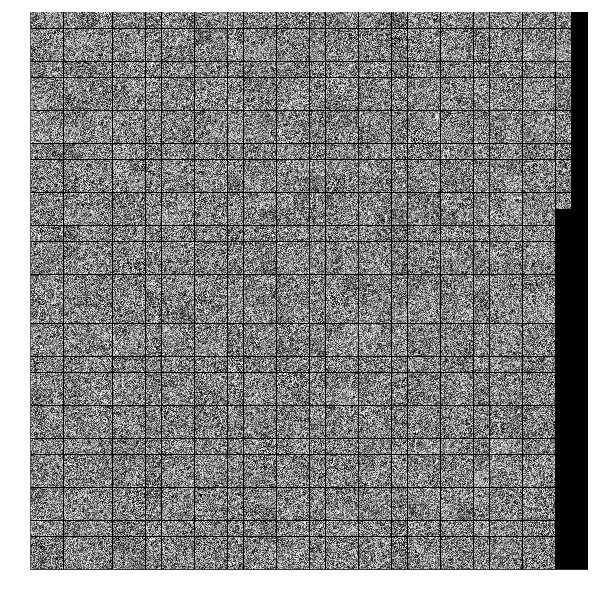

(1100, 1700)
(1700, 300)
(300, 800)


In [6]:
nbpixels = 28*28
for name, layer in layers.items():
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2 and (W.shape[0] == nbpixels or W.shape[1] == nbpixels):
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            W = W.reshape((W.shape[0], c, w, h))
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[1] in (1, 3):
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[0] in (1, 3):
            W = W.transpose((1, 2, 3, 0))
            W = W * np.ones((1, 1, 1, 3))
        else:
            print(W.shape)
            continue
        print(layer.name)
        fig = plt.figure(figsize=(10, 10))
        plt.axis('off')
        img = dispims_color(W, border=1)
        plt.imshow(img, interpolation='none')
        plt.show()

In [7]:
X = data.X[0:100]
X=capsule.preprocess(X)

In [8]:
Xrec = capsule.reconstruct(X)

In [9]:
C = encode(X)
Xrec = decode(*C)

NameError: name 'encode' is not defined

In [ ]:
a=C[2].flatten()
a=a[a>0]
plt.hist(a)

In [ ]:
C = list(encode(X))
cc = []
for i in cc:
    C[i][:] = 0
    
"""
M = (1,)
for i in M:
    F = C[i].shape[1]
    W = C[i].shape[2]
    H = C[i].shape[3]
    C[i][np.arange(C[i].shape[0]), 
         np.random.randint(0, F, size=C[i].shape[0]), 
         np.random.randint(0, W, size=C[i].shape[0]), 
         np.random.randint(0, H, size=C[i].shape[0])] = 100
"""

fig = plt.figure(figsize=(20, 20))
Xrec = decode(*C)
recons = dispims_color(Xrec.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1, bordercolor=(0.5,0.5,0.5))
plt.imshow(recons)

In [ ]:
orig = dispims_color(X.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
recons = dispims_color(Xrec.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1)
imsave('orig.png', orig)
imsave('recons.png', recons)
fig = plt.figure(figsize=(10, 10))
plt.imshow(recons)

In [ ]:
for i in range(256):
    xx = X[10:11]
    a, b, c = encode(xx)
    inds = c.max(axis=(2, 3)) > 0
    inds = np.arange(c.shape[1])[inds[0]]
    
    #for m in range(i):
    #    plt.imshow(c[0, inds[m]])
    #    plt.show()
    c[0, inds[0:i]] = 0
    C = [a, b, c]
    Xrec = decode(*C)

    #orig = dispims_color(xx.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
    
    recons = dispims_color(Xrec.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1)
    #imsave('orig.png', orig)
    #imsave('recons.png', recons)
    fig = plt.figure(figsize=(2, 2))
    plt.imshow(recons, interpolation='none')
    plt.show()

## iterative refinement

In [10]:
from data import load_data
c=1
if c == 3:
    external_data = load_data(dataset='lfw', w=w, h=h)
    external_data = external_data.X
    external_data = external_data.reshape((external_data.shape[0], c, w, h))
    
if c == 1:
    from lasagnekit.datasets.rescaled import Rescaled
    external_data = load_data(dataset='digits', w=w, h=h)
    external_data = Rescaled(external_data, (w, h))
    external_data.load()
    external_data = external_data.X[0:100]
    external_data = external_data.reshape((external_data.shape[0], c, w, h))
    external_data = external_data.astype(np.float32)

genetic = False
if genetic:
    external_data = np.random.uniform(size=external_data.shape).astype(np.float32)

    layer_name = 'wta_spatial'
    x = T.tensor4()
    px_to_code = theano.function(
        [x],
        L.get_output(layers[layer_name], x)
    )
    code_to_px = theano.function(
        [x],
        L.get_output(layers["output"], {layers[layer_name]: x}))

    def crossover(A, nb=100):
        S = np.zeros((nb,) + A.shape[1:])
        for i in range(nb):
            ind1, ind2 = np.random.randint(0, A.shape[0], size=2)
            s1, s2 = A[ind1], A[ind2]
            s = np.zeros_like(s1)
            c = np.random.randint(0, 2, size=A.shape[1])
            s[c == 0] = s1[c == 0]
            s[c == 1] = s2[c == 1]
            S[i] = s
        return S.astype(np.float32)

    def smarter_mutation(A, born_perc=0.1, dead_perc=0.1, nbtimes=1, val=10, nb=100):
        # val = A.max()
        perc = born_perc + dead_perc
        nb_filters = A.shape[1]
        size = int(perc * nb_filters)
        for i in range(nbtimes):
            for a in A:
                indices = np.random.choice(np.arange(a.shape[1]),#was a  bug in the old genetic
                                           size=size, replace=True)
                nb_born = int(born_perc*nb_filters)
                born_indices = indices[0:nb_born]
                dead_indices = indices[nb_born:]
                a[dead_indices] = 0
                for idx in born_indices:
                    a[idx] = 0
                    x, y = np.random.randint(a.shape[1]), np.random.randint(a.shape[2])
                    # val = np.random.choice((0.01, 0.1, 1, 10))
                    #val = np.random.uniform()
                    a[idx, x, y] = val
        return A


    codes = px_to_code(external_data)
    codes = crossover(codes, nb=codes.shape[0])
    codes = smarter_mutation(codes, born_perc=0, dead_perc=0.9)
    external_data = code_to_px(codes)

In [15]:
seed = 42
np.random.seed(seed)
N = 100 # nb of examples to generate
nb_iter = 100 # nb iterations for generation
do_sample = False
do_binarize = True
do_noise = False
noise_pr = 0.5
init_by_external = False

if init_by_external:
    s = floatX(external_data[0:N])
else:
    s = floatX(np.random.uniform(0, 1, size=(N, c, w, h)) > 0.8)
print(s.shape)
samples = []
samples.append(s.copy()[np.newaxis, :, :, :, :])

loss = []
for i in tqdm(range(nb_iter)):
    sprev = s      
    if do_noise:
        s = (np.random.uniform(size=s.shape) <= (1 - noise_pr)) * s
        s = s.astype(np.float32)
    s = (capsule.reconstruct(s))
    samples.append(s.copy()[np.newaxis, :, :, :, :])

    if do_sample:
        s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    if do_binarize:
        s = s > 0.5
    score = np.abs(s - sprev).sum()
    print(score)
    if score == 0:
        break
    #print(score)
    loss.append(score)
samples = np.concatenate(samples, axis=0) # all samples from all timesteps in an array

(100, 1, 28, 28)


  0%|          | 0/100 [00:00<?, ?it/s]

16100.0


  1%|          | 1/100 [00:01<02:57,  1.79s/it]/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/ipykernel/__main__.py:32: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


1807


  2%|▏         | 2/100 [00:03<02:55,  1.79s/it]

2504


  3%|▎         | 3/100 [00:05<02:53,  1.78s/it]

3416


  4%|▍         | 4/100 [00:07<02:51,  1.78s/it]

4845


  5%|▌         | 5/100 [00:08<02:49,  1.78s/it]

4975


  6%|▌         | 6/100 [00:10<02:47,  1.78s/it]

4329


  7%|▋         | 7/100 [00:12<02:45,  1.78s/it]

3937


  8%|▊         | 8/100 [00:14<02:43,  1.78s/it]

4799


  9%|▉         | 9/100 [00:16<02:42,  1.78s/it]

6458


 10%|█         | 10/100 [00:17<02:40,  1.78s/it]

6434


 11%|█         | 11/100 [00:19<02:38,  1.78s/it]

5089


 12%|█▏        | 12/100 [00:21<02:36,  1.78s/it]

3469


 13%|█▎        | 13/100 [00:23<02:35,  1.78s/it]

3672


 14%|█▍        | 14/100 [00:24<02:33,  1.78s/it]

4046


 15%|█▌        | 15/100 [00:26<02:31,  1.78s/it]

4212


 16%|█▌        | 16/100 [00:28<02:29,  1.78s/it]

4995


 17%|█▋        | 17/100 [00:30<02:27,  1.78s/it]

5125


 18%|█▊        | 18/100 [00:32<02:26,  1.78s/it]

5214


 19%|█▉        | 19/100 [00:33<02:24,  1.78s/it]

5808


 20%|██        | 20/100 [00:35<02:22,  1.78s/it]

6963


 21%|██        | 21/100 [00:37<02:20,  1.78s/it]

7328


 22%|██▏       | 22/100 [00:39<02:18,  1.78s/it]

6357


 23%|██▎       | 23/100 [00:40<02:17,  1.78s/it]

5930


 24%|██▍       | 24/100 [00:42<02:15,  1.78s/it]

5618


 25%|██▌       | 25/100 [00:44<02:13,  1.78s/it]

4773


 26%|██▌       | 26/100 [00:46<02:11,  1.78s/it]

6435


 27%|██▋       | 27/100 [00:48<02:09,  1.78s/it]

4759


 28%|██▊       | 28/100 [00:49<02:08,  1.78s/it]

3149


 29%|██▉       | 29/100 [00:51<02:06,  1.78s/it]

3755


 30%|███       | 30/100 [00:53<02:05,  1.79s/it]

4254


 31%|███       | 31/100 [00:55<02:03,  1.79s/it]

3896


 32%|███▏      | 32/100 [00:57<02:02,  1.80s/it]

4135


 33%|███▎      | 33/100 [00:58<02:00,  1.80s/it]

4449


 34%|███▍      | 34/100 [01:00<01:59,  1.80s/it]

3967


 35%|███▌      | 35/100 [01:02<01:57,  1.80s/it]

4936


 36%|███▌      | 36/100 [01:04<01:55,  1.80s/it]

5136


 37%|███▋      | 37/100 [01:06<01:53,  1.81s/it]

5429


 38%|███▊      | 38/100 [01:07<01:51,  1.81s/it]

6033


 39%|███▉      | 39/100 [01:09<01:50,  1.81s/it]

5355


 40%|████      | 40/100 [01:11<01:48,  1.81s/it]

4879


 41%|████      | 41/100 [01:13<01:46,  1.81s/it]

6180


 42%|████▏     | 42/100 [01:15<01:44,  1.81s/it]

4990


 43%|████▎     | 43/100 [01:16<01:42,  1.81s/it]

3905


 44%|████▍     | 44/100 [01:18<01:41,  1.81s/it]

4451


 45%|████▌     | 45/100 [01:20<01:39,  1.81s/it]

5812


 46%|████▌     | 46/100 [01:22<01:37,  1.81s/it]

6302


 47%|████▋     | 47/100 [01:24<01:35,  1.81s/it]

6426


 48%|████▊     | 48/100 [01:25<01:33,  1.81s/it]

4801


 49%|████▉     | 49/100 [01:27<01:32,  1.81s/it]

3762


 50%|█████     | 50/100 [01:29<01:30,  1.81s/it]

4532


 51%|█████     | 51/100 [01:31<01:28,  1.81s/it]

4909


 52%|█████▏    | 52/100 [01:33<01:26,  1.81s/it]

5149


 53%|█████▎    | 53/100 [01:35<01:25,  1.81s/it]

5340


 54%|█████▍    | 54/100 [01:36<01:23,  1.81s/it]

7144


 55%|█████▌    | 55/100 [01:38<01:21,  1.81s/it]

7607


 56%|█████▌    | 56/100 [01:40<01:19,  1.81s/it]

5881


 57%|█████▋    | 57/100 [01:42<01:17,  1.81s/it]

3880


 58%|█████▊    | 58/100 [01:44<01:15,  1.81s/it]

3937


 59%|█████▉    | 59/100 [01:45<01:14,  1.81s/it]

4247


 60%|██████    | 60/100 [01:47<01:12,  1.81s/it]

4804


 61%|██████    | 61/100 [01:49<01:10,  1.81s/it]

5032


 62%|██████▏   | 62/100 [01:51<01:08,  1.81s/it]

6300


 63%|██████▎   | 63/100 [01:53<01:06,  1.81s/it]

4809


 64%|██████▍   | 64/100 [01:54<01:05,  1.81s/it]

3822


 65%|██████▌   | 65/100 [01:56<01:03,  1.81s/it]

4505


 66%|██████▌   | 66/100 [01:58<01:01,  1.81s/it]

4080


 67%|██████▋   | 67/100 [02:00<00:59,  1.81s/it]

4965


 68%|██████▊   | 68/100 [02:02<00:57,  1.81s/it]

5592


 69%|██████▉   | 69/100 [02:03<00:56,  1.81s/it]

5344


 70%|███████   | 70/100 [02:05<00:54,  1.81s/it]

6684


 71%|███████   | 71/100 [02:07<00:52,  1.81s/it]

6989


 72%|███████▏  | 72/100 [02:09<00:50,  1.81s/it]

5219


 73%|███████▎  | 73/100 [02:11<00:48,  1.81s/it]

4239


 74%|███████▍  | 74/100 [02:12<00:47,  1.81s/it]

5107


 75%|███████▌  | 75/100 [02:14<00:45,  1.81s/it]

5845


 76%|███████▌  | 76/100 [02:16<00:43,  1.81s/it]

5120


 77%|███████▋  | 77/100 [02:18<00:41,  1.81s/it]

5676


 78%|███████▊  | 78/100 [02:20<00:39,  1.81s/it]

6478


 79%|███████▉  | 79/100 [02:22<00:37,  1.81s/it]

5410


 80%|████████  | 80/100 [02:23<00:36,  1.81s/it]

5252


 81%|████████  | 81/100 [02:25<00:34,  1.81s/it]

4542


 82%|████████▏ | 82/100 [02:27<00:32,  1.81s/it]

5667


 83%|████████▎ | 83/100 [02:29<00:30,  1.81s/it]

6146


 84%|████████▍ | 84/100 [02:31<00:28,  1.81s/it]

6102


 85%|████████▌ | 85/100 [02:32<00:27,  1.81s/it]

5570


 86%|████████▌ | 86/100 [02:34<00:25,  1.81s/it]

4357


 87%|████████▋ | 87/100 [02:36<00:23,  1.81s/it]

4257


 88%|████████▊ | 88/100 [02:38<00:21,  1.81s/it]

5819


 89%|████████▉ | 89/100 [02:40<00:19,  1.81s/it]

5782


 90%|█████████ | 90/100 [02:41<00:18,  1.81s/it]

5374


 91%|█████████ | 91/100 [02:43<00:16,  1.81s/it]

5044


 92%|█████████▏| 92/100 [02:45<00:14,  1.81s/it]

6155


 93%|█████████▎| 93/100 [02:47<00:12,  1.81s/it]

6237


 94%|█████████▍| 94/100 [02:49<00:10,  1.81s/it]

4671


 95%|█████████▌| 95/100 [02:50<00:09,  1.81s/it]

3080


 96%|█████████▌| 96/100 [02:52<00:07,  1.81s/it]

3726


 97%|█████████▋| 97/100 [02:54<00:05,  1.81s/it]

4385


 98%|█████████▊| 98/100 [02:56<00:03,  1.81s/it]

4451


 99%|█████████▉| 99/100 [02:58<00:01,  1.81s/it]

4286


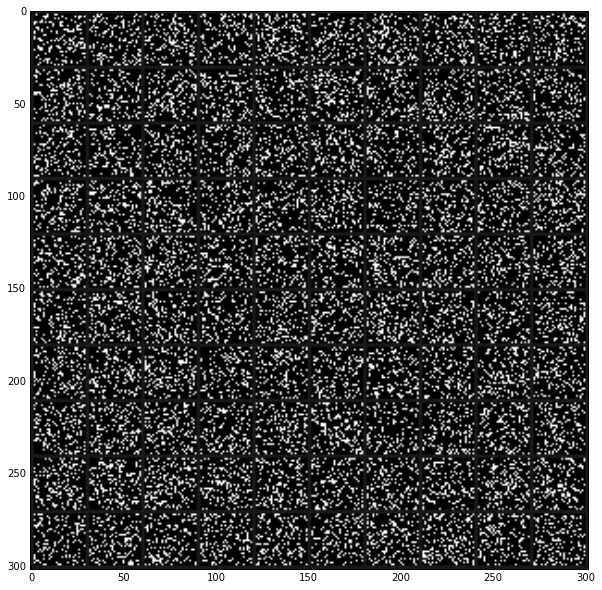

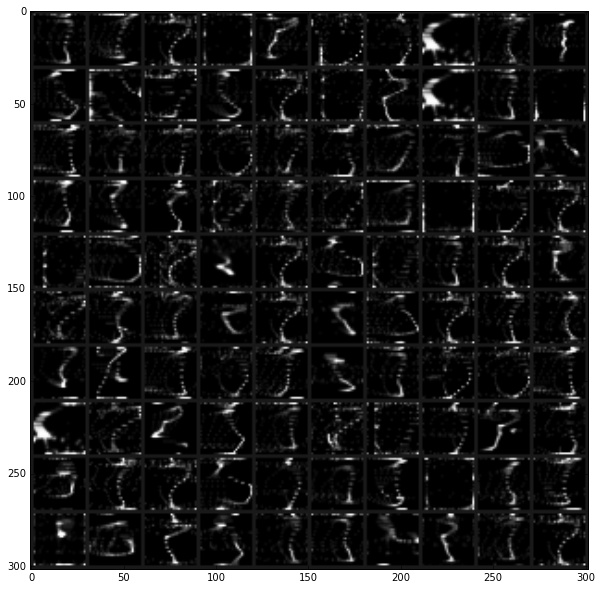

In [16]:
# show images generated at last iteration
for s in (samples[0], samples[-1]):
    s = s * np.ones((1, 3, 1, 1))
    s = s.transpose((0, 2, 3, 1))
    fig = plt.figure(figsize=(10, 10))
    img = dispims_color(s, border=2, bordercolor=(0.1, 0.1, 0.1), )
    imsave('out.png', img)
    plt.imshow(img)

In [ ]:
# sample samples and iterations
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
img = dispims_color(samples_, shape=(sw, sh))
imsave('out.png', img)
plt.imshow(img)
plt.axis('off')
plt.show()

## project into feature space

In [ ]:
hid = []
d = []
for i in range(1):
    d.append(capsule.preprocess(external_data).transpose((0, 2 ,3 , 1))  * np.ones((1, 1, 1, 3)))
    C = encode(capsule.preprocess(external_data))
    if type(C) == list:
        C = [c.reshape(c.shape[0], -1) for c in C]
        C = C[-1]
        #C = np.concatenate(C, axis=1)
        
    hid.append(C)
d = np.concatenate(d, axis=0)
print(hid[0].shape)
hid = np.concatenate(hid, axis=0)
hid = hid.reshape((hid.shape[0], -1))

In [ ]:
mf = PCA(n_components=2)
h2d = mf.fit_transform(hid)

In [ ]:
mf = PCA(n_components=2)
d2d = mf.fit_transform(d.reshape(d.shape[0], -1))

In [ ]:
img = image_scatter(h2d, d, 10)
imsave('out_scatter.png', img)
plt.imshow(img)
plt.show()

In [ ]:
img = image_scatter(d2d, d, 80)
imsave('out_scatter_data.png', img)
plt.imshow(img)
plt.show()

## transferability

In [ ]:
X_transf_orig = external_data[0:500]


X_transf_rec = X_transf_orig.copy().astype(np.float32)
X_transf_rec = X_transf_rec
imgs = []
for i in tqdm(range(100)):
    X_transf_rec = X_transf_rec + (capsule.reconstruct(X_transf_rec) - X_transf_rec)
    imgs.append(X_transf_rec.copy())
    
from scripts import imgtovideo
x = []
for img in imgs:
    img = img * np.ones((1, 3, 1, 1))
    img = img.transpose((0, 2, 3, 1))
    x.append(dispims_color(img))


In [ ]:
imgtovideo.imgs_to_video(x, out='out.mp4', verbose=1)

In [ ]:
X_transf = X_transf_orig.transpose((0, 2, 3, 1))
X_transf = X_transf * np.ones((1, 1, 1, 3))

X_transf_rec = X_transf_rec.transpose((0, 2, 3, 1))
X_transf_rec = X_transf_rec * np.ones((1, 1, 1, 3))

In [ ]:
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf_rec[0:500])
plt.imshow(img, cmap='gray')
plt.show()
fig = plt.figure(figsize=(20, 20))
img = dispims_color(X_transf[0:500])
plt.imshow(img, cmap='gray')
plt.show()

## forced generation

In [ ]:
import pickle
from lasagne import layers

def load_model(filename):
    data = pickle.load(open(filename))
    print()
    gen = data['generator']
    discr = data['discriminator']
    gen_weights = data['generator_weights']
    discr_weights = data['discriminator_weights']
    layers.set_all_param_values(gen, gen_weights)
    layers.set_all_param_values(discr, discr_weights)
    return gen, discr

In [ ]:
gen, discr = load_model('/home/mcherti/work/code/lasagne-dcgan/fonts.pkl')

## rnn

In [ ]:
X = T.tensor4()
Xinit = X
nb_steps = 4
for i in range(nb_steps):
    X = L.get_output(layers['output'], X)
score = L.get_output(discr, X)
loss = (score).mean()
grad = theano.grad(loss, Xinit)
get_grad = theano.function([Xinit], grad)
get_loss = theano.function([Xinit], loss)
get_gen = theano.function([Xinit], X)

In [ ]:
import scipy
def eval_loss(x0):
    x0 = x0.reshape((nb, c, w, h))
    return -get_loss(x0.astype(np.float32)).astype('float64')

def eval_grad(x0):
    x0 = x0.reshape((nb, c, w, h))
    return get_grad(x0.astype(np.float32)).flatten().astype('float64')

In [ ]:
nb = 100
x = np.random.uniform(size=(nb, c, w, h))
x = x.astype(np.float32)
for i in range(40):
    #x, _, _ = scipy.optimize.fmin_l_bfgs_b(eval_loss, x.flatten(), fprime=eval_grad, maxfun=1)
    #x = x.reshape((nb, c, w, h)).astype(np.float32)
    x += 0.1 * get_grad(x)
    print(get_loss(x))

In [ ]:
img = get_gen(x) * np.ones((1, 3, 1, 1))
img = img.transpose((0, 2, 3, 1))
fig = plt.figure(figsize=(10, 10))
img = dispims_color(img, border=1, bordercolor=(10, 10, 10))
plt.imshow(img)

In [ ]:
## classif

In [ ]:
from datakit.mnist import MNIST
data = MNIST('train')
data.load()
X_train = data.X.reshape((data.X.shape[0], 1, 28, 28))
y_train = data.y
def transform(X):
    h = []
    for i in range(0, X.shape[0], 128):
        C = encode(X[i:i + 128])
        hh = np.concatenate([cc.max(axis=(2, 3)).reshape((cc.shape[0], -1)) for cc in C], axis=1)      
        h.append(hh)
    h = np.concatenate(h, axis=0)
    return h

X_train = transform(X_train)

data = MNIST('test')
data.load()
X_test = data.X.reshape((data.X.shape[0], 1, 28, 28))
X_test = transform(X_test)
y_test = data.y

In [ ]:
Xrec = capsule.reconstruct(data.)